In [2]:
import sys; sys.path.insert(0, '..')

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

import trajectory_reconstruction_tradeoff as T
import random
import scanpy as sc
import altair as alt
from altair_saver import save

random.seed(20)

In [3]:
dirname = '../output/datasets/' 
outdir = '../output/results/'

datasets = ['linear',
            'bifur_at_1',
            'bifur_at_2',
            'bifur_at_3',
            'bifur_at_1_to_3',
            'bifur_at_2_to_3',
            'bifur_at_1_to_4',
            ]

# colors = ['blue', 'darkred', 'maroon', 'brown', 'firebrick', 'indianred', 'lightcoral', ]
colors = {'linear': 'navy', 
          'bifur_at_1': 'blue', 
          'bifur_at_2': 'deepskyblue',#'cyan', 
          'bifur_at_3': 'aquamarine', 
          'bifur_at_1_to_3': 'lightsalmon', 
          'bifur_at_2_to_3': 'tomato', 
          'bifur_at_1_to_4': 'red', }

dims = {'linear': 1,
        'bifur_at_1': 2,
        'bifur_at_2': 2,
        'bifur_at_3': 2,
        'bifur_at_1_to_3': 3,
        'bifur_at_2_to_3': 3,
        'bifur_at_1_to_4': 4,
        }

In [4]:
# # params
# Pvar = np.round(0.03 * 2 ** np.arange(0, 5, 0.6), 2)
# Pconst = np.ones_like(Pvar)
# repeats = 10

In [4]:
# # read all data
# ndims = 4
# fig, ax = plt.subplots(ndims, 3, figsize=(20,20))
# shift = 0.25
# trajs = {}
# ndatas = 1
# dim_count = np.zeros(ndims).astype(int)
# for dataset in datasets:
#     datafiles = glob.glob(os.path.join(dirname, f'{dataset}_rep*.h5ad'))
#     for datafile in datafiles[:ndatas]:
#         print(datafile)
#         dataname = os.path.basename(datafile).split('.')[0]
#         adata = sc.read_h5ad(datafile)
#         X = adata.X
#         meta = adata.obs
#         traj = T.tr.Trajectory(X, meta=meta)
#         d = int(dims[dataset] - 1)
#         ax[d, dim_count[d]].scatter(traj.pX[:,0]-shift, traj.pX[:,1]-shift, color=colors[dataset])
#         T.pl.plot_pca2d(traj.pX, meta=meta, title=dataset, color='branch', ax=ax[d, dim_count[d]])
#         # ax[d, dim_count[d]].set_title(dataset)
#         dim_count[d]+=1
#         trajs[dataname] = traj

In [5]:
# ndatasets = 10
# postfix = '_single.csv' if ndatasets == 1 else '.csv'

L_reads = pd.read_csv(os.path.join(outdir, 'prosstt_L_reads.csv'))
L_cells = pd.read_csv(os.path.join(outdir, 'prosstt_L_cells.csv'))

In [6]:
# compute transformations
L_cells['inv pc'] = 1 / L_cells['pc']
L_reads['inv pt'] = 1 / L_reads['pt']
L_cells['log pc'] = np.log(L_cells['pc'])
L_reads['log pt'] = np.log(L_reads['pt'])
L_reads['log l1'] = np.log(L_reads['l1'])
L_cells['log l1'] = np.log(L_cells['l1'])

# deltas
ncells = 1000
L_cells['delta'] = L_cells['Delta0'] / L_cells['pc'] / ncells
L_cells['log delta'] = np.log(L_cells['delta'])

# compute npaths
islinear = L_cells['trajectory type'] == 'linear' 
L_cells['dim'] = L_cells.apply(lambda x: dims[x['trajectory type']], axis=1)
L_cells['nbranches'] = L_cells['dim'] + 1
L_cells.loc[islinear,'nbranches'] = 1
L_cells['npaths'] = L_cells.apply(lambda x: comb(x['nbranches'], 2), axis=1)

### Visualize

In [14]:
L_cells.groupby(['level_0', 'pc'])['Delta0'].mean().reset_index().groupby(['level_0'])['Delta0'].var().mean()

0.3286149148252215

In [ ]:
# fig, ax = plt.subplots(1, figsize=(6,6))
# pc_dims = np.arange(10)

# ax.set_title('Cell downsample dimensions')
# for data in datasets:
#     color = colors[data]
#     sL = L_cells[L_cells['trajectory type'] == data].copy()
#     pc_means = sL[['Delta%d' % pc_dim for pc_dim in pc_dims]].mean()
#     ax.plot(np.log(pc_dims), pc_means, color=color, linewidth=4, label=data)
    
# ax.legend()

In [7]:
# print('PCA dimensions reflect the dimension of the tree')
# fig, ax = plt.subplots(1, figsize=(6,6))
# pc_dims = np.arange(10)

# ax.set_title('Cell downsample dimensions')
# for data in datasets:
#     color = colors[data]
#     sL = L_cells[L_cells['trajectory type'] == data].copy()
#     pc_means = sL[['Delta%d' % pc_dim for pc_dim in pc_dims]].mean()
#     ax.plot(np.log(pc_dims), pc_means, color=color, linewidth=4, label=data)
    
# ax.legend()

In [16]:
# ## Visualizing previous statements
# print('We currently do not model well bifurcating trajectories. However, trends seem to be explainable')
# nplots = 4
# fig, ax = plt.subplots(1, nplots, figsize=(5*nplots,5))

# ax[0].set_title(r'Read downsample, $\epsilon_t \sim log(p_t)$')
# for data in datasets:
#     color = colors[data]
#     dim = dims[data]
#     sL = L_reads[L_reads['trajectory type'] == data].copy()
#     T.pl.plot_tradeoff(sL, xcol='log pt', ycol='l1', color_mean=color, color_std=color, label=data, 
#     ax=ax[0], plot_std=0, xlabel=r'$log(p_t)$', ylabel=r'$\epsilon_t$')

# ax[1].set_title(r'Cell downsample - linear, $log(\epsilon_c) \sim log(p_c)$')
# for data in datasets:
#     color = colors[data]
#     dim = dims[data]
#     sL = L_cells[L_cells['trajectory type'] == data].copy()
#     T.pl.plot_tradeoff(sL, xcol='log pc', ycol='log l1', color_mean=color, color_std=color, label=data, 
#     ax=ax[1], plot_std=0, xlabel=r'$log(p_c)$', ylabel=r'$log(\epsilon_c)$')

# ax[2].set_title(r'Cell downsample - linear, $\epsilon_c \sim p_c$')
# for data in datasets:
#     color = colors[data]
#     dim = dims[data]
#     sL = L_cells[L_cells['trajectory type'] == data].copy()
#     T.pl.plot_tradeoff(sL, xcol='pc', ycol='l1', color_mean=color, color_std=color, label=data, 
#     ax=ax[2], plot_std=0, xlabel=r'$p_c$', ylabel=r'$\epsilon_c$')


# ax[3].set_title(r'Cell downsample - bifurcating, $log(\epsilon_c) \sim log(\delta)$')
# for data in datasets:
#     color = colors[data]
#     dim = dims[data]
#     sL = L_cells[L_cells['trajectory type'] == data].copy()
#     ssL = sL.groupby('pc')[['log delta', 'log l1']].mean()
#     T.pl.plot_tradeoff(ssL, xcol='log delta', ycol='log l1', color_mean=color, color_std=color, label=data, 
#     ax=ax[3], plot_std=0, xlabel=r'$log(\delta)$', ylabel=r'$log(\epsilon_c)$')
    

# ax[nplots-1].legend()
# plt.tight_layout()


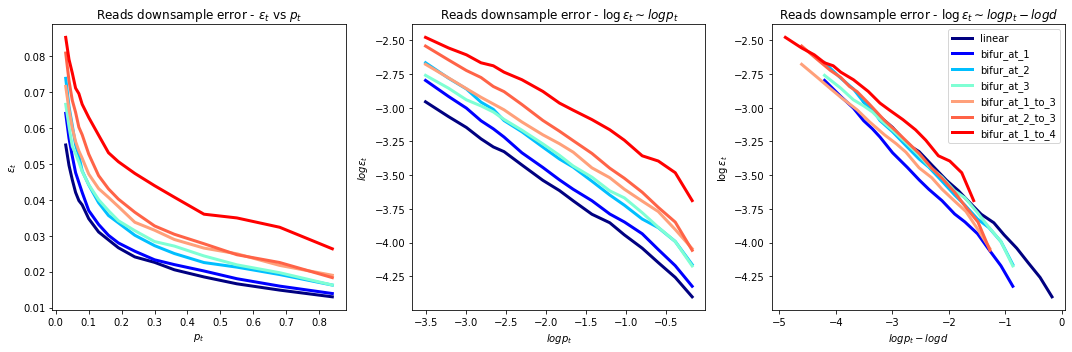

In [7]:
# READS only
nplots = 3
fig, ax = plt.subplots(1, nplots, figsize=(5*nplots,5))

ax[0].set_title(r'Reads downsample error - $\epsilon_t$ vs $p_t$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_reads[L_reads['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='pt', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[0], plot_std=0, xlabel=r'$p_t$', ylabel=r'$\epsilon_t$')


ax[1].set_title(r'Reads downsample error - $\log \epsilon_t \sim log p_t$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_reads[L_reads['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pt'] 
    T.pl.plot_tradeoff(sL, xcol='tmp', ycol='log l1', color_mean=color, color_std=color, label=data, 
    ax=ax[1], plot_std=0, xlabel=r'$log p_t$', ylabel=r'$log \epsilon_t$')

ax[2].set_title(r'Reads downsample error - $\log \epsilon_t \sim log p_t - log d$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_reads[L_reads['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pt'] - np.log(dim)
    T.pl.plot_tradeoff(sL, xcol='tmp', ycol='log l1', color_mean=color, color_std=color, label=data, 
    ax=ax[2], plot_std=0, xlabel=r'$log p_t - log d$', ylabel=r'$\log \epsilon_t$')

# ax[3].set_title(r'Delta downsample error - $\Delta$ vs $p_t$')
# for data in datasets:
#     color = colors[data]
#     dim = dims[data]
#     sL = L_reads[L_reads['trajectory type'] == data].copy()
#     T.pl.plot_tradeoff(sL, xcol='log pt', ycol='Delta0', color_mean=color, color_std=color, label=data, 
#     ax=ax[3], plot_std=0, xlabel=r'$log p_t$', ylabel=r'$\Delta$')


plt.tight_layout()
ax[nplots-1].legend()

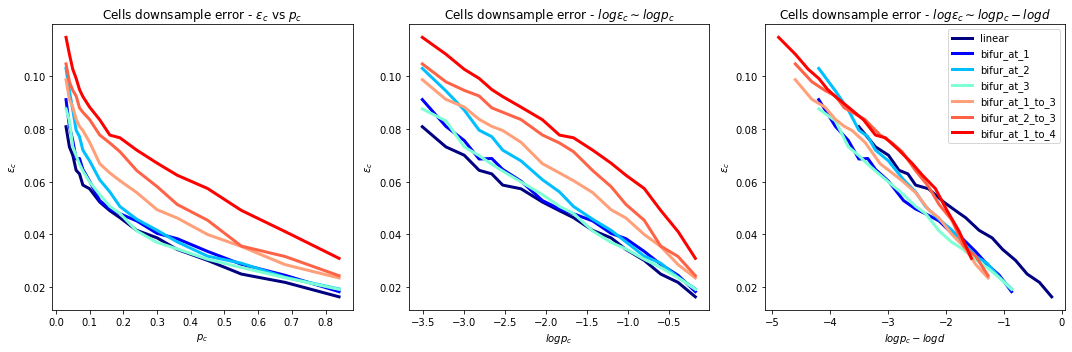

In [78]:
# CELLS only
nplots = 3
fig, ax = plt.subplots(1, nplots, figsize=(5*nplots,5))

ax[0].set_title(r'Cells downsample error - $\epsilon_c$ vs $p_c$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='pc', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[0], plot_std=0, xlabel=r'$p_c$', ylabel=r'$\epsilon_c$')

ax[1].set_title(r'Cells downsample error - $log \epsilon_c \sim log p_c$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pc'] 
    T.pl.plot_tradeoff(sL, xcol='tmp', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[1], plot_std=0, xlabel=r'$log p_c$', ylabel=r'$\epsilon_c$')

ax[2].set_title(r'Cells downsample error - $log \epsilon_c \sim log p_c - log d$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pc'] - np.log(dim)
    T.pl.plot_tradeoff(sL, xcol='tmp', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[2], plot_std=0, xlabel=r'$log p_c - log d$', ylabel=r'$\epsilon_c$')

plt.tight_layout()
ax[nplots-1].legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


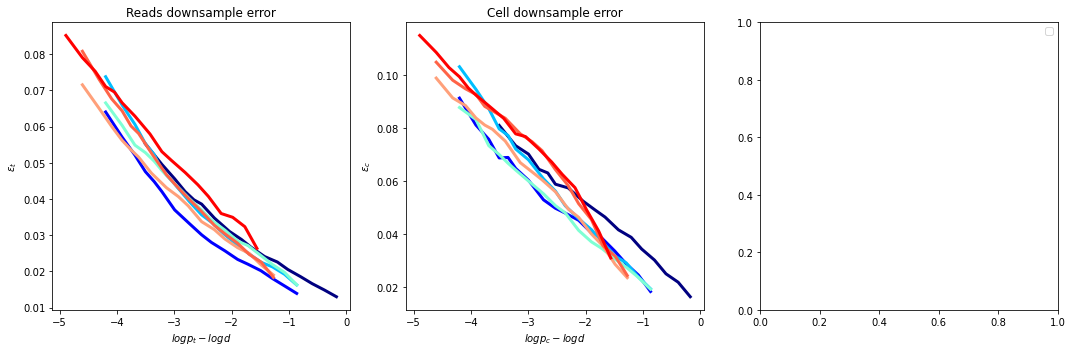

In [6]:
## Visualizing current
nplots = 3
fig, ax = plt.subplots(1, nplots, figsize=(5*nplots,5))

ax[0].set_title(r'Reads downsample error')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_reads[L_reads['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pt'] - np.log(dim)
    T.pl.plot_tradeoff(sL, xcol='tmp', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[0], plot_std=0, xlabel=r'$log p_t - log d$', ylabel=r'$\epsilon_t$')

ax[1].set_title(r'Cell downsample error')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pc'] - np.log(dim)
    T.pl.plot_tradeoff(sL, xcol='tmp', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[1], plot_std=0, xlabel=r'$log p_c - log d$', ylabel=r'$\epsilon_c$')

# ax[2].set_title(r'Cell downsample, $log(\epsilon_c) \sim p_c$')
# for data in datasets:
#     color = colors[data]
#     dim = dims[data]
#     npaths = comb(dim+1, 2) if dim > 1 else 1
#     # print(f'{data}, {dim}')
#     sL = L_cells[L_cells['trajectory type'] == 'linear'].copy()
#     # sL['tmp'] = (sL['log l1'] * (((sL['pc'])**((dim-1))))) 
#     sL['tmp'] = np.log(sL['l1']**(sL['pc']**(dim-1)))
    
#     # sL = L_cells[L_cells['trajectory type'] == 'linear'].copy()
#     # sL['tmp'] = (sL['pc']**(dim/2)) * sL['log l1']
#     T.pl.plot_tradeoff(sL, xcol='log pc', ycol='tmp', color_mean=color, color_std=color, label=data, 
#     ax=ax[2], plot_std=0, xlabel=r'$log p_c$', ylabel=r'$log(\epsilon^{linear}_c) p_c^{d-1}$')
# # ax[2].set_ylim([-6,0])

ax[nplots-1].legend()
plt.tight_layout()


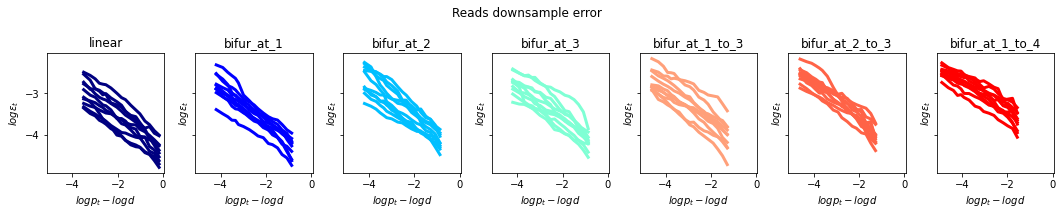

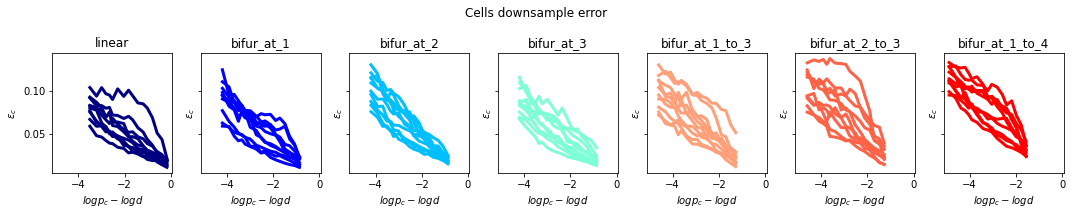

In [8]:
fig, ax = plt.subplots(1, len(datasets), figsize=(5*nplots,3), sharex=True, sharey=True)
for idata, data in enumerate(datasets):
    color = colors[data]
    dim = dims[data]
    sL = L_reads[L_reads['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pt'] - np.log(dim)
    ax[idata].set_title(data)
    for r in sL['level_0'].unique():
        ssL = sL[sL['level_0'] == r]
        T.pl.plot_tradeoff(ssL, xcol='tmp', ycol='log l1', color_mean=color, color_std=color, label=data, 
        ax=ax[idata], plot_std=0, xlabel=r'$log p_t - log d$', ylabel=r'$log \epsilon_t$')
plt.suptitle(r'Reads downsample error')
plt.tight_layout()

fig, ax = plt.subplots(1, len(datasets), figsize=(5*nplots,3), sharex=True, sharey=True)
for idata, data in enumerate(datasets):
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    sL['tmp'] = sL['log pc'] - np.log(dim)
    ax[idata].set_title(data)
    for r in sL['level_0'].unique():
        ssL = sL[sL['level_0'] == r]
        T.pl.plot_tradeoff(ssL, xcol='tmp', ycol='l1', color_mean=color, color_std=color, label=data, 
        ax=ax[idata], plot_std=0, xlabel=r'$log p_c - log d$', ylabel=r'$\epsilon_c$')
plt.suptitle(r'Cells downsample error')


# ax[1, -1].legend()
plt.tight_layout()


In [76]:
sL.groupby('log pc').mean()['log l1'].diff().mean()

-0.08604276314736656

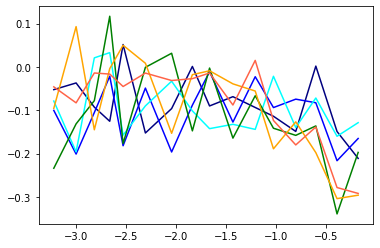

In [85]:
for data in datasets:
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    grp_sL = sL.groupby('log pc').mean()
    der = grp_sL['log l1'].diff().iloc[1:]
    npaths = grp_sL['npaths'].mean()
    plt.plot(der.index, der.values, color=colors[data])

Avg slope of linear trajectory: -1.000


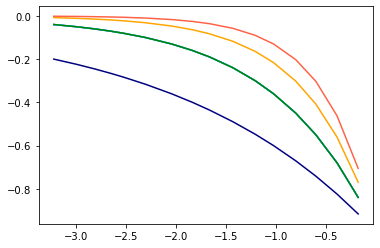

In [100]:
# prediction
# suppose for linear, slope is const

sL = L_cells[L_cells['trajectory type'] == 'linear'].copy()
grp_sL = sL.groupby('log pc').mean()
pcs = grp_sL['pc'].values[1:]
der = grp_sL['log l1'].diff().iloc[1:]
xvals = der.index
linear_slope = -1#der.mean()
print('Avg slope of linear trajectory: %.03f' % linear_slope)

# for bifurcating, 
for data in datasets:

    sL = L_cells[L_cells['trajectory type'] == data].copy()
    dim = sL['dim'].mean()
    pred_der = linear_slope * (pcs)**(dim/2)
    plt.plot(xvals, pred_der, color=colors[data])

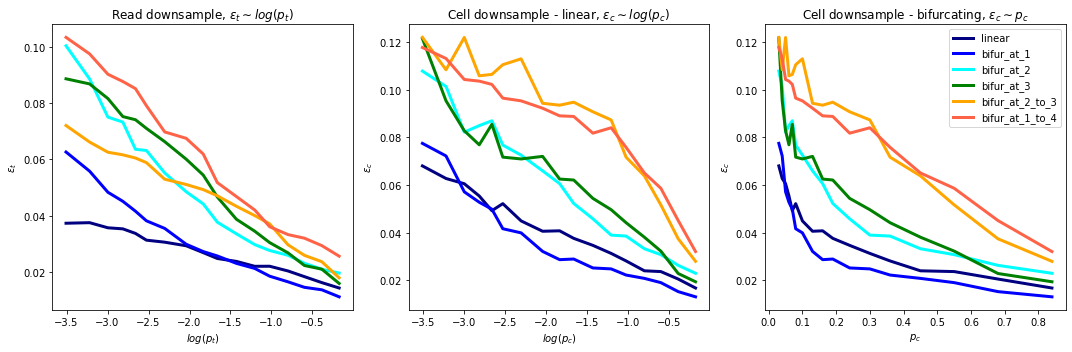

In [26]:
## Visualizing without log on error
nplots = 3
fig, ax = plt.subplots(1, nplots, figsize=(5*nplots,5))

ax[0].set_title(r'Read downsample, $\epsilon_t \sim log(p_t)$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_reads[L_reads['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='log pt', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[0], plot_std=0, xlabel=r'$log(p_t)$', ylabel=r'$\epsilon_t$')

ax[1].set_title(r'Cell downsample - linear, $\epsilon_c \sim log(p_c)$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='log pc', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[1], plot_std=0, xlabel=r'$log(p_c)$', ylabel=r'$\epsilon_c$')

ax[2].set_title(r'Cell downsample - bifurcating, $\epsilon_c \sim p_c$')
for data in datasets:
    color = colors[data]
    dim = dims[data]
    sL = L_cells[L_cells['trajectory type'] == data].copy()
    T.pl.plot_tradeoff(sL, xcol='pc', ycol='l1', color_mean=color, color_std=color, label=data, 
    ax=ax[2], plot_std=0, xlabel=r'$p_c$', ylabel=r'$\epsilon_c$')
    

ax[nplots-1].legend()
plt.tight_layout()


In [14]:
for dataset in datasets:
    sL = L_reads[L_reads['trajectory type'] == dataset].copy()
    sL.index = sL['log pt']
    median_slope = np.round(sL['l1'].diff().iloc[1:].median(), 5)
    print(f'{dataset} slope: {median_slope}')

linear slope: -0.04445
bifur_at_1 slope: -0.09237
bifur_at_2 slope: -0.09844
bifur_at_3 slope: -0.09382
bifur_at_1_to_3 slope: -0.06899
bifur_at_2_to_3 slope: -0.05219
bifur_at_1_to_4 slope: -0.07146


In [15]:
for dataset in datasets:
    sL = L_cells[L_cells['trajectory type'] == dataset].copy()
    sL.index = sL['log pc']
    median_slope = np.round(sL['l1'].diff().iloc[1:].median(), 5)
    print(f'{dataset} slope: {median_slope}')

linear slope: -0.11778
bifur_at_1 slope: -0.11376
bifur_at_2 slope: -0.13815
bifur_at_3 slope: -0.06062
bifur_at_1_to_3 slope: -0.03727
bifur_at_2_to_3 slope: -0.18924
bifur_at_1_to_4 slope: -0.06342


## Tradeoff

In [60]:
# Bs = [0.0001, 0.001, 0.01]

# Pc = Pvar
# L_tradeoff_dict = {}
# for traj_name, traj in trajs.items():
#     L_tradeoff_per_traj = []
#     for B in Bs:
#         L_tradeoff_per_traj.append(traj.compute_tradeoff(B=B, Pc=Pc, repeats=repeats))
#     L_tradeoff_dict[traj_name] = pd.concat(L_tradeoff_per_traj)

In [7]:
L_tradeoff = pd.read_csv(os.path.join(outdir, 'prosstt_L_tradeoff.csv'))

In [8]:
L_tradeoff['log pc'] = np.log(L_tradeoff['pc'])

In [9]:
Bs = L_tradeoff['B'].unique()

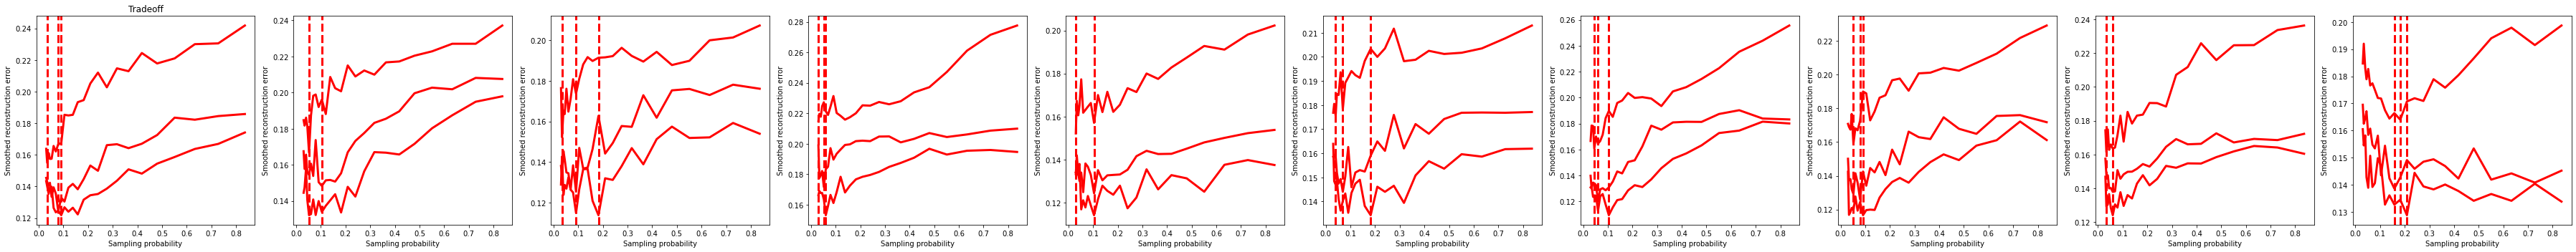

In [25]:
# examine single structure
data = 'bifur_at_1_to_4'
sL = L_tradeoff[L_tradeoff['trajectory type'] == data]
repeats = sL['level_0'].unique()
nrepeats = len(repeats)
fig, ax = plt.subplots(1, nrepeats, figsize=(5*nrepeats,5))
color = colors[data]

ax[0].set_title('Tradeoff')
for ir, r in enumerate(repeats):
    ssL = sL[sL['level_0'] == r]
    for B in Bs:
        sssL = ssL[ssL['B'] == B]
        pc_opt = T.opt.find_min_nc(sssL)
        T.pl.plot_tradeoff(sssL, xcol='pc', color_mean=color, color_std=color, label=data, ax=ax[ir], plot_std=0, pc_opt=pc_opt)
    # ax[ir].set_title(data)

plt.tight_layout()

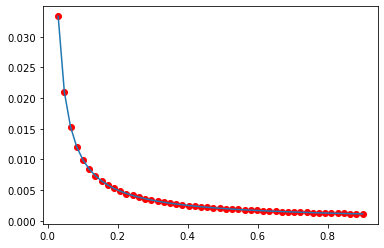

In [33]:
# Pvar = np.round(0.03 * 1.5 ** np.arange(0, 5, 0.2), 3)
Pvar = np.linspace(0.03, 0.9, 50)
Pvar2 = B / Pvar
plt.plot(Pvar, Pvar2)
plt.scatter(Pvar, Pvar2, c='r')

In [26]:
np.round(0.03 * 2 ** np.arange(0, 5, 0.2), 3)

array([0.03 , 0.034, 0.04 , 0.045, 0.052, 0.06 , 0.069, 0.079, 0.091,
       0.104, 0.12 , 0.138, 0.158, 0.182, 0.209, 0.24 , 0.276, 0.317,
       0.364, 0.418, 0.48 , 0.551, 0.633, 0.728, 0.836])

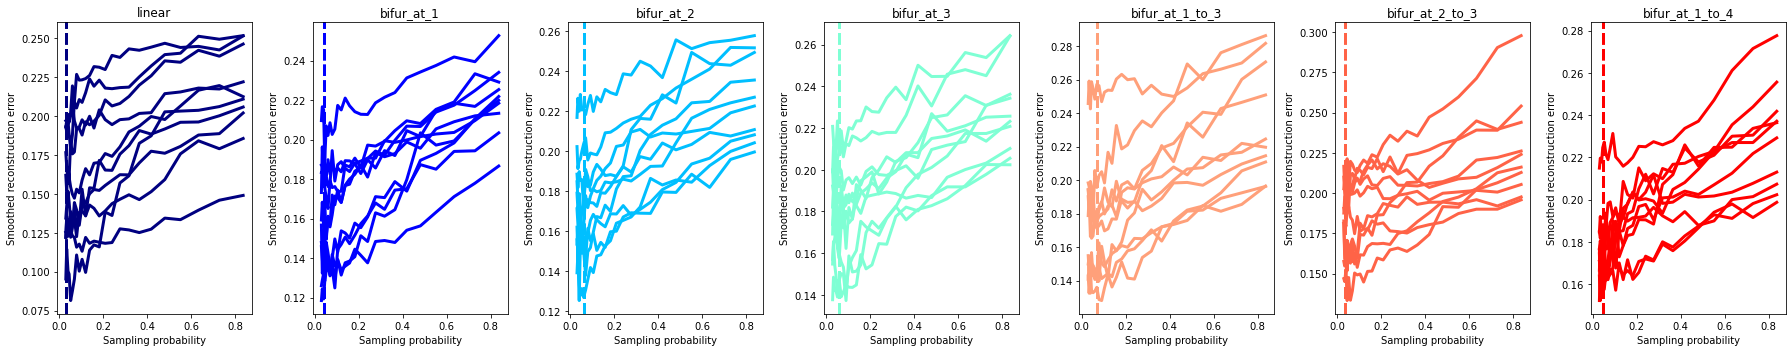

In [21]:
fig, ax = plt.subplots(1, len(datasets), figsize=(25,5))
B = Bs[0]

ax[0].set_title('Tradeoff')
for idata, data in enumerate(datasets):
    sL = L_tradeoff[L_tradeoff['trajectory type'] == data]
    ssL = sL[sL['B'] == B]
    # sL = L_tradeoff[L_tradeoff['level_0'] == data + '_rep1']
    color = colors[data]
    for r in sL['level_0'].unique():
        sssL = ssL[ssL['level_0'] == r]
        pc_opt = T.opt.find_min_nc(ssL)
        T.pl.plot_tradeoff(sssL, xcol='pc', color_mean=color, color_std=color, label=data, ax=ax[idata], plot_std=0, pc_opt=pc_opt)
    ax[idata].set_title(data)

plt.tight_layout()

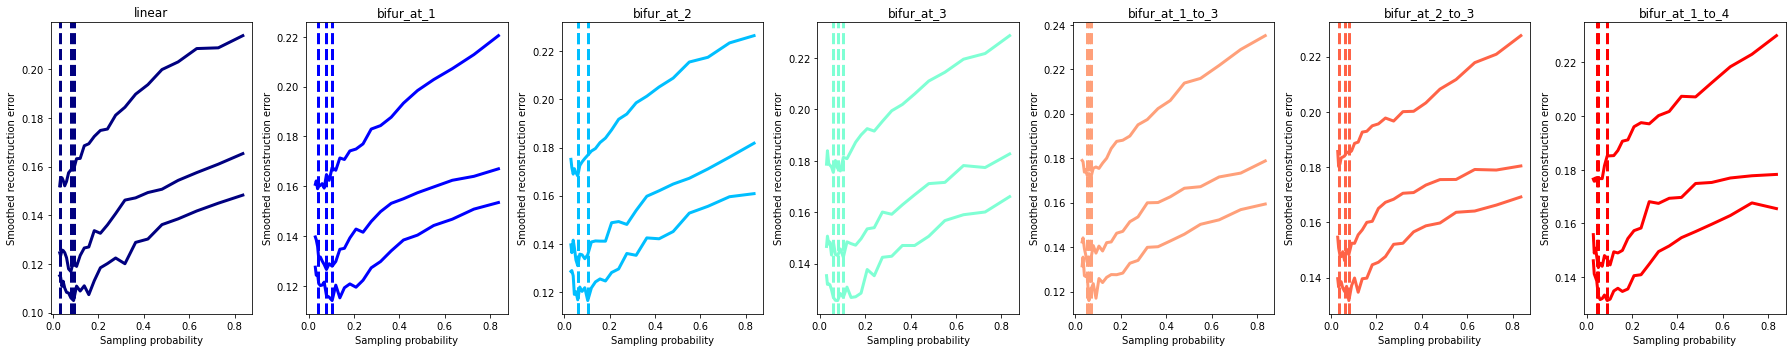

In [12]:
fig, ax = plt.subplots(1, len(datasets), figsize=(25,5))

ax[0].set_title('Tradeoff')
for idata, data in enumerate(datasets):
    sL = L_tradeoff[L_tradeoff['trajectory type'] == data]
    # sL = L_tradeoff[L_tradeoff['level_0'] == data + '_rep1']
    color = colors[data]
    for B in Bs:
        ssL = sL[sL['B'] == B]
        pc_opt = T.opt.find_min_nc(ssL)
        T.pl.plot_tradeoff(ssL, xcol='pc', color_mean=color, color_std=color, label=data, ax=ax[idata], plot_std=0, pc_opt=pc_opt)
    ax[idata].set_title(data)

plt.tight_layout()